<a href="https://colab.research.google.com/github/Sanjanaverma459/week-2/blob/main/Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Import required libraries
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
# ✅ Extracting the zip file
zip_path = "archive.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped to:", extract_path)


✅ Dataset unzipped to: /content/data


In [4]:
import os
import zipfile

# ✅ 1. Unzip the archive (if not already done)
zip_path = "/content/archive.zip"
extract_path = "/content/archive"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("✅ Archive extracted successfully.")

# ✅ 2. Set the dataset path
dataset_path = "/content/archive/TrashType_Image_Dataset"

# ✅ 3. List the class names
if os.path.exists(dataset_path):
    class_names = os.listdir(dataset_path)
    print("✅ Classes in dataset:", class_names)

else:
    print("❌ Dataset path not found. Check if folder name is correct.")

✅ Archive extracted successfully.
✅ Classes in dataset: ['glass', 'metal', 'paper', 'plastic', 'trash', 'cardboard']


In [5]:
# 🔍 List all subdirectories and help find the correct path
for root, dirs, files in os.walk("/content/data"):
    print(root)


/content/data
/content/data/TrashType_Image_Dataset
/content/data/TrashType_Image_Dataset/glass
/content/data/TrashType_Image_Dataset/metal
/content/data/TrashType_Image_Dataset/paper
/content/data/TrashType_Image_Dataset/plastic
/content/data/TrashType_Image_Dataset/trash
/content/data/TrashType_Image_Dataset/cardboard


In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ✅ Parameters
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
seed = 123

# ✅ Create training dataset
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# ✅ Create validation dataset
val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# ✅ Print class names
class_names = train_ds.class_names
print("📂 Classes:", class_names)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
📂 Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B2

# ✅ Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ✅ Load EfficientNetV2B2
base_model = EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)  # or (img_height, img_width, 3)
)
base_model.trainable = True  # Start with unfreezing

# ✅ Freeze bottom 70% of layers
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# ✅ Build the model
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 classes
])

# ✅ Compile with a low learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Summary
model.summary()


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 4,701,900 (17.94 MB)

 Non-trainable params: 4,067,474 (15.52 MB)

In [10]:
# Fine-tune the new model
fine_tune_epochs = 15  # or 20 if time allows

history_aug = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.1831 - loss: 1.7870 - val_accuracy: 0.2495 - val_loss: 1.7649
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.2171 - loss: 1.7671 - val_accuracy: 0.2337 - val_loss: 1.7534
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 308s 5s/step - accuracy: 0.2150 - loss: 1.7646 - val_accuracy: 0.2416 - val_loss: 1.7472
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.2232 - loss: 1.7475 - val_accuracy: 0.2535 - val_loss: 1.7374
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.2170 - loss: 1.7506 - val_accuracy: 0.2574 - val_loss: 1.7257
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.2284 - loss: 1.7466 - val_accuracy: 0.2594 - val_loss: 1.7221
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.2183 - loss: 1.7573 - val_accuracy: 0.2950 - val_loss: 1.7137
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.2167 - loss: 1.7383 - val_accuracy: 0.2970 - v

In [13]:
# ✅ Train for more epochs (Phase 2 Fine-tuning)
more_epochs = 15  # You can adjust to 10–20 based on patience

history_fine_more = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=more_epochs
)


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.2253 - loss: 1.7280 - val_accuracy: 0.3109 - val_loss: 1.6848
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.2391 - loss: 1.7224 - val_accuracy: 0.3050 - val_loss: 1.6858
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.2208 - loss: 1.7345 - val_accuracy: 0.3030 - val_loss: 1.6822
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.2276 - loss: 1.7171 - val_accuracy: 0.3069 - val_loss: 1.6815
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.2204 - loss: 1.7345 - val_accuracy: 0.3050 - val_loss: 1.6808
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.2217 - loss: 1.7286 - val_accuracy: 0.3109 - val_loss: 1.6802
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.2505 - loss: 1.7193 - val_accuracy: 0.3208 - val_loss: 1.6810
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.2368 - loss: 1.7236 - val_accuracy: 0.3228 - v

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


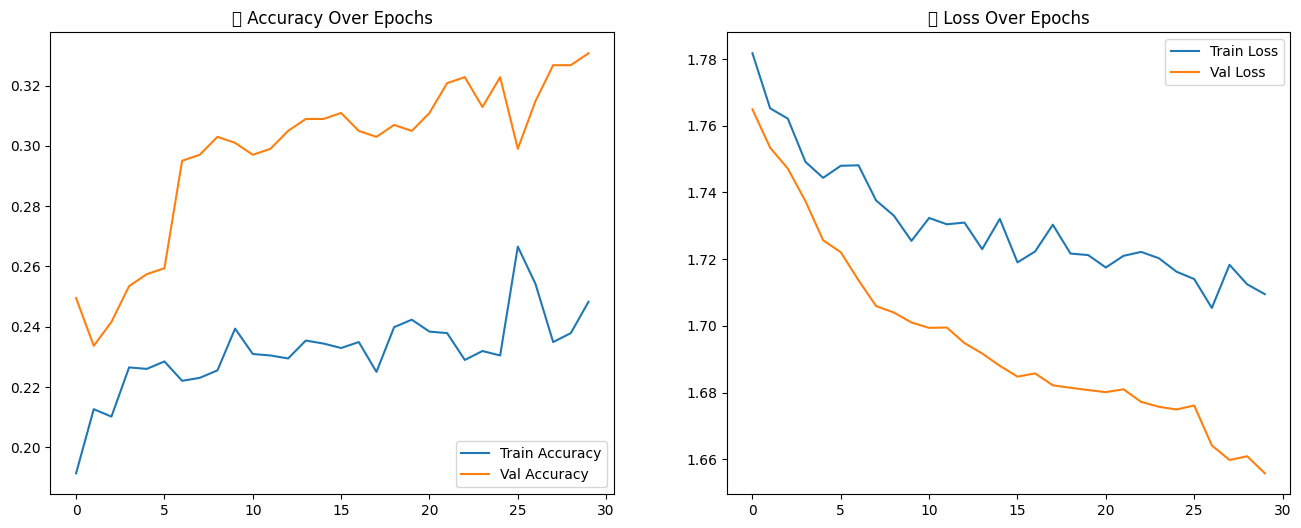

In [16]:
import matplotlib.pyplot as plt

# ✅ Fix: Define total_epochs
total_epochs = len(history_aug.history['accuracy']) + len(history_fine_more.history['accuracy'])

# ✅ Combine metrics from both training phases
acc = history_aug.history['accuracy'] + history_fine_more.history['accuracy']
val_acc = history_aug.history['val_accuracy'] + history_fine_more.history['val_accuracy']

loss = history_aug.history['loss'] + history_fine_more.history['loss']
val_loss = history_aug.history['val_loss'] + history_fine_more.history['val_loss']

epochs_range = range(total_epochs)

# ✅ Plot graphs
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('📈 Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('📉 Loss Over Epochs')

plt.show()

In [15]:
import numpy as np  # ✅ Add this at the top

# ⚠️ Only works if val_ds is not shuffled/batched
val_images = []
val_labels = []

for images, labels in val_ds.unbatch().take(1000):  # Use 1000 samples to speed things up
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# ✅ Predict class probabilities
pred_probs = model.predict(val_images, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# ✅ Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(val_labels, pred_labels, target_names=class_names))


16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        83
       glass       0.28      0.60      0.38       103
       metal       0.00      0.00      0.00        78
       paper       0.56      0.46      0.51       124
     plastic       0.27      0.55      0.36        88
       trash       0.00      0.00      0.00        29

    accuracy                           0.33       505
   macro avg       0.18      0.27      0.21       505
weighted avg       0.24      0.33      0.26       505



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


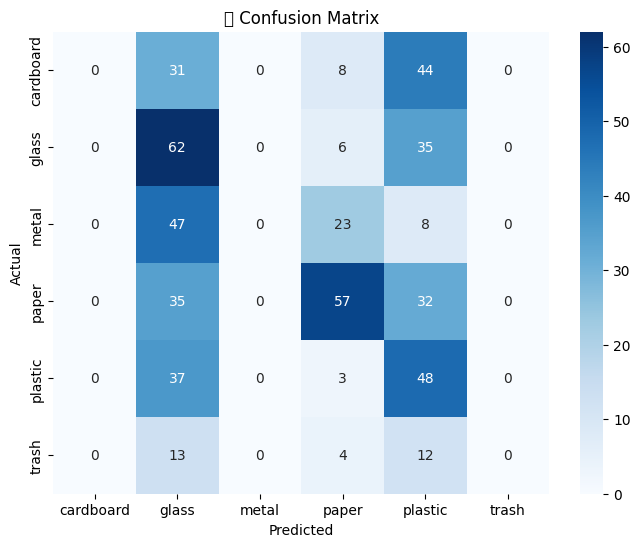

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(val_labels, pred_labels)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧾 Confusion Matrix")
plt.show()


In [20]:
from google.colab import files
uploaded = files.upload()


Saving cardboard_339.jpg to cardboard_339.jpg


In [21]:
from tensorflow.keras.preprocessing import image
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction[0])]
confidence = np.max(prediction[0]) * 100

print(f"📦 Predicted: {predicted_class} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
📦 Predicted: plastic (24.84%)
